Note book to assess precipitation efficiency in Rosi's MPAS aquaplanet simulations

### Main settings

In [76]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
from scipy import stats
import numpy as np

#### Read data

In [77]:
# data_path = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/CTL/TC_3km/'
data_path = '../../../pickle_out/aquaplanet/'
test_names = ["CTL","HOMO_RAD"]
ntest = len(test_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil']
# pclass_names=["Deep", "Congestus", "Shallow", "Stratiform", "Anvil"]#, "DSA"] # DSA isn't there yet
nclass = len(pclass_names)

In [78]:
# Get list of files
def get_file_list():
    import subprocess
    file_list = {}
    for itest in range(ntest):
        process = subprocess.Popen(['ls '+data_path+'*'+test_names[itest]+'*'],shell=True,
            stdout=subprocess.PIPE,universal_newlines=True)
        file_list[test_names[itest]] = process.stdout.readlines()
        for ifile in range(len(file_list[test_names[itest]])):
            file_list[test_names[itest]][ifile] = file_list[test_names[itest]][ifile].strip()
            # file_list[test_names[itest]][ifile] = file_list[test_names[itest]][ifile].split('/')[-1]
    nfiles = len(file_list[test_names[0]])
    times = np.arange(0, nfiles)/4
    return file_list, times

file_list, times = get_file_list()

In [79]:
PE_massFlux = {}
for expName in test_names:
    PE_massFlux[expName] = {}
    for iname in pclass_names:
        PE_massFlux[expName][iname] = []
    for pickle_file in file_list[expName]:
        # Read in variables from pickle
        with open(pickle_file, 'rb') as f:
            PE_thisExp = pickle.load(f)
        for ikey in PE_thisExp.keys():
            PE_massFlux[expName][ikey].append(PE_thisExp[ikey])
    for iclass in pclass_names:
        PE_massFlux[expName][iclass] = np.array(PE_massFlux[expName][iclass])

### Plotting

#### Time series

In [80]:
# Function to compute running mean
def running_mean_conf(time_series):
    nd_smooth    = 6 # days
    nd_window_ci = 6
    # nd_smooth    = 20 # days
    # nd_window_ci = 20
    ntpday = 4 # timesteps per day
    window_size = nd_smooth*ntpday  # Adjust as needed
    window_size_ci = nd_window_ci*ntpday  # Adjust as needed
    tser_smooth = np.convolve(time_series, np.ones(window_size) / window_size, mode='valid')
    tser_ci = np.convolve(time_series, np.ones(window_size_ci) / window_size_ci, mode='valid')
    # Compute standard error of the mean
    standard_error = stats.sem(time_series)  # Standard error of the original data
    z_score = 1.96 # Z-score for 95% confidence interval
    confidence_interval = z_score * standard_error  # 95% confidence interval
    # confidence_interval = np.zeros_like(tser_ci)
    # # for i in range(len(tser_smooth)):
    # for i in range(len(tser_ci)):
    #     subset = time_series[i:i+window_size_ci]
    #     standard_error = stats.sem(subset)
    #     confidence_interval[i] = z_score * standard_error
    #     # Q1 = np.percentile(subset, 25)
    #     # Q3 = np.percentile(subset, 75)
    #     # IQR = Q3 - Q1
    #     # confidence_interval[i] = IQR/2
    return tser_smooth, confidence_interval, window_size, tser_ci, window_size_ci

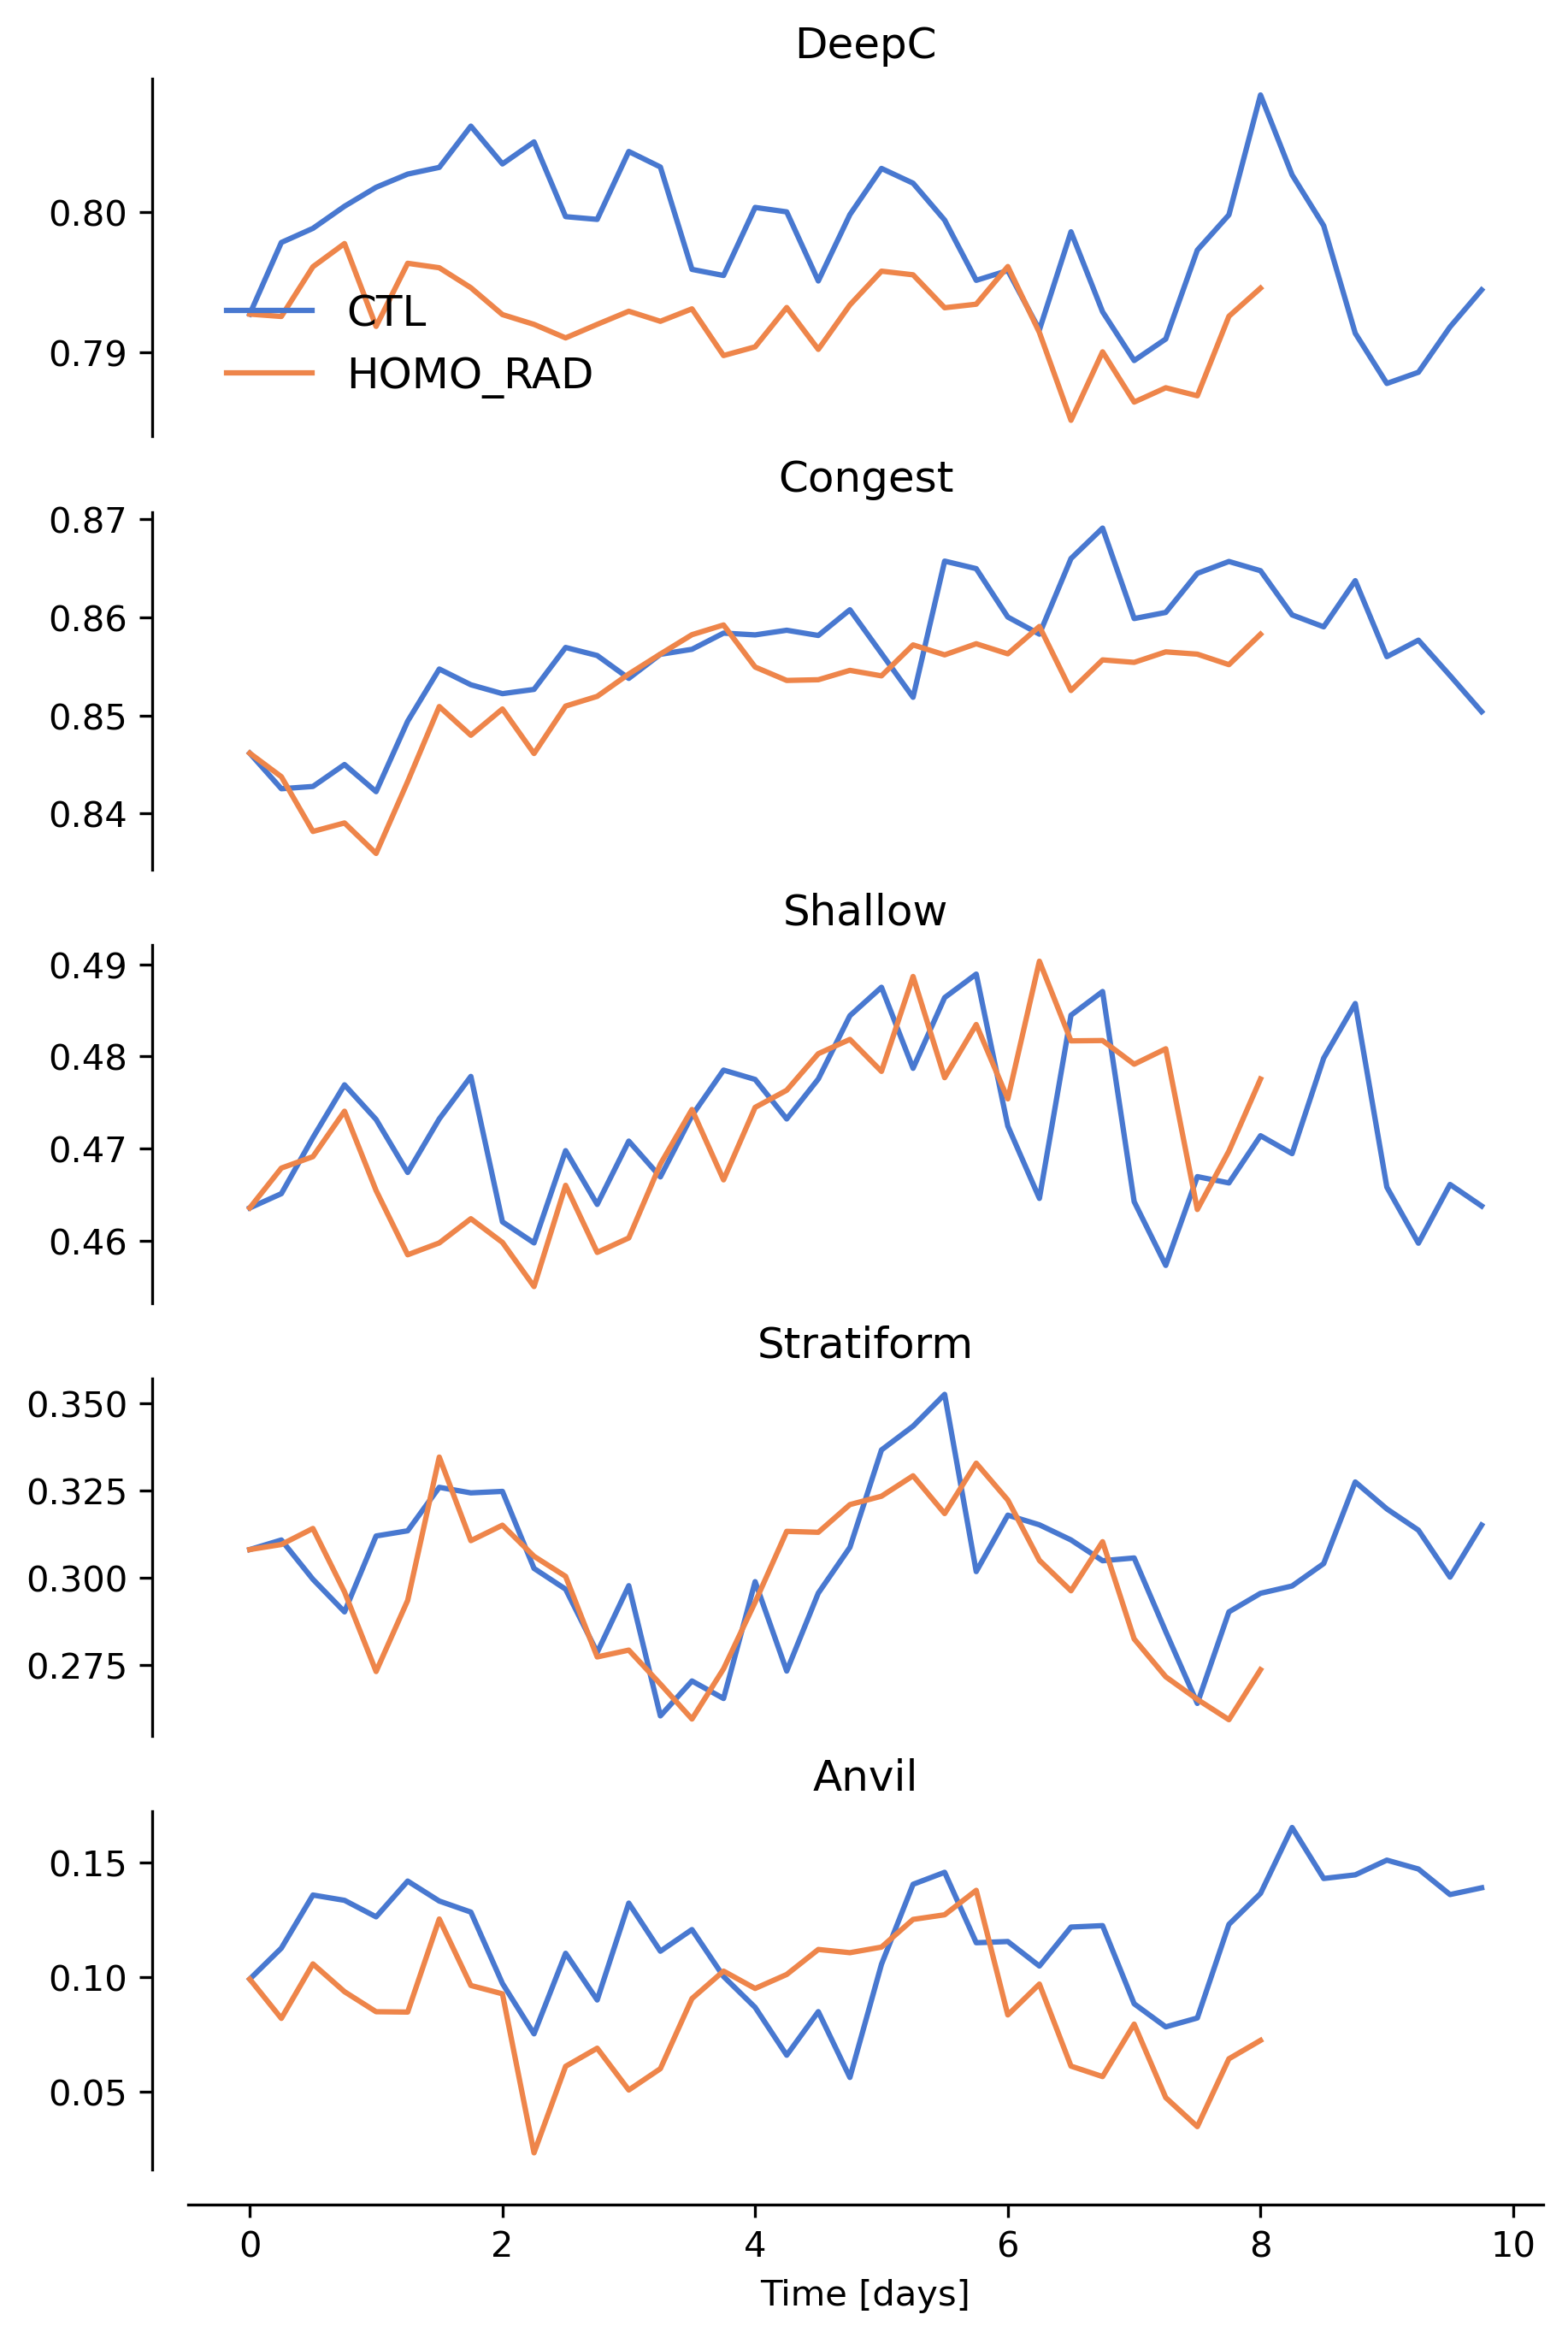

In [81]:
# create figure
fig_x = 6
fig_y = 1.6*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)#, squeeze=True) # row, column
sns.set_palette('muted')
# fig.suptitle(title)
# if ctlanom:
#     pltvar -= pltvar[:,0,:][:,np.newaxis,:]
# Plot all sensitivity tests for variable
for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])

    for itest in test_names:
        tser = PE_massFlux[itest][pclass_names[iclass]]
        i_nt = len(tser)
        iax.plot(times[:i_nt], tser, linewidth=1.5, label=itest)
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()